# Global Circulation in a Tidally Locked Exoplanet: Seasonal Variability
Simulations and analysis by Caleb Keaveney for ASTR 575: Exoplanets


Seven simulations run for 1000 days (years) using the ISCA GCM at $\epsilon = 0, 15, 30, 45, 60, 75, 90$. Held-Suarez (Newtonian cooling with bottom boundary drag) forcing modified to allow for obliquity variations and set the orbital and rotation periods equal to 24 hours. All forcing values are kept the same, so the planet is Earth-like except for the obliquity and that it is tidally locked.  

Simulations run on YCRC's Grace cluster.

One modification made to the ISCA code to fix a bug. isca/src/shared/astronomy/astronomy.f90, modified the diurnal_exoplanet subroutine to properly calculate the time since aphelion. Also modified batch script to run simulations.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.animation as anim
import matplotlib.ticker as ticker
import PIL
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import scipy.integrate as integrate

### Animation of equilibrium temperature profile: shows effect of obliquity in forcing the GCM

In [ ]:
data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity45/run0100/atmos_hourly.nc',decode_times=False)
time = data.time
lon = data.lon
lat = data.lat
pfull = data.pfull
u = data.ucomp
v = data.vcomp
omega = data.omega
temp = data.temp
vort = data.vor
tbar = np.mean(np.mean(temp,axis=0),axis=2)
teq = data.teq
height = data.height

vmin = 210
vmax = 265

image_frames = []
for t in range(teq.shape[0]):
    print(t)
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('black')
    ax = fig.add_subplot(1,1,1, projection=ccrs.Orthographic(central_longitude=120,central_latitude=0))
    ax.contourf(lon,lat,teq[t,14],transform=ccrs.PlateCarree(),levels=np.linspace(vmin,vmax,100),cmap='gnuplot2',extend='both')
    plt.savefig('/home/cwk26/project/plots/astr575/obliq45/teq/'+str(t)+'.png',dpi=300)

    new_frame = PIL.Image.open('/home/cwk26/project/plots/astr575/obliq45/teq/'+str(t)+'.png')
    image_frames.append(new_frame)
    plt.close()
    plt.clf()

image_frames[0].save('/home/cwk26/project/plots/astr575/obliq45/teq/obliq45_teq.gif',
                     format = 'GIF',
                     append_images = image_frames[1: ], 
                     save_all = True, 
                     duration = 100, 
                     loop = 0)

### Time-average equilibrium temperature profile for all cases: shows variable forcing due to obliquity

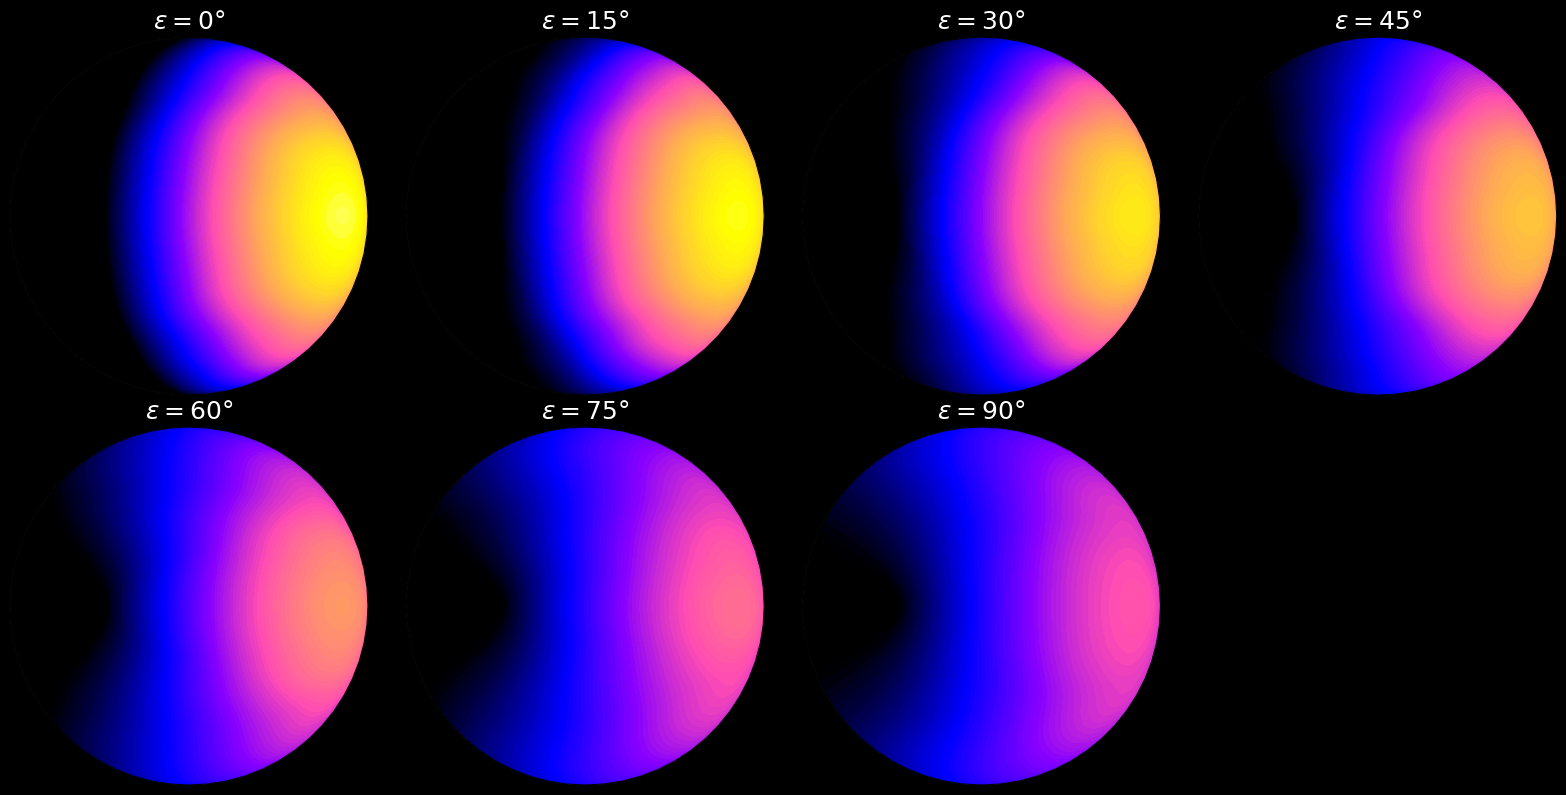

In [49]:
run = ['0', '15', '30', '45', '60', '75', '90']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8),
                         subplot_kw={'projection': ccrs.Orthographic(central_longitude=120, central_latitude=0)})
fig.patch.set_facecolor('black')

# Set color limits
vmin = 210
vmax = 265

for t in range(len(run)):
    data = xr.open_dataset(f'/home/cwk26/project/gfdl_data/top_down_test_obliquity{run[t]}/run0100/atmos_hourly.nc', decode_times=False)
    
    lon = data.lon
    lat = data.lat
    teq = data.teq

    ax = axes.flatten()[t]
    ax.set_global()
    
    cax = ax.contourf(lon, lat, teq[:, 14].mean('time'),
                      transform=ccrs.PlateCarree(),
                      levels=np.linspace(vmin, vmax, 100),
                      cmap='gnuplot2', extend='both')
    ax.set_title(r'$\epsilon = $'+run[t]+'$\degree$',fontsize=18,color='white')

# Remove empty subplot if number of runs is less than total subplots
if len(run) < len(axes.flatten()):
    for i in range(len(run), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])

# Add colorbar
#cbar = fig.colorbar(cax, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05)
#cbar.set_label('Temperature (K)')  # or appropriate label

plt.tight_layout()
plt.show()

### Zonal Wind, Temperature, and Relative Vorticity for zero obliquity case

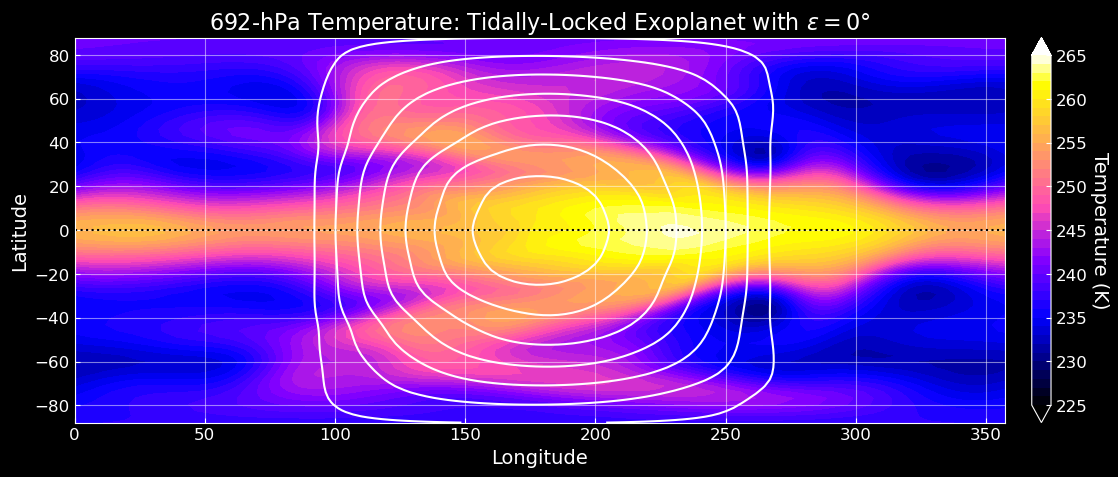

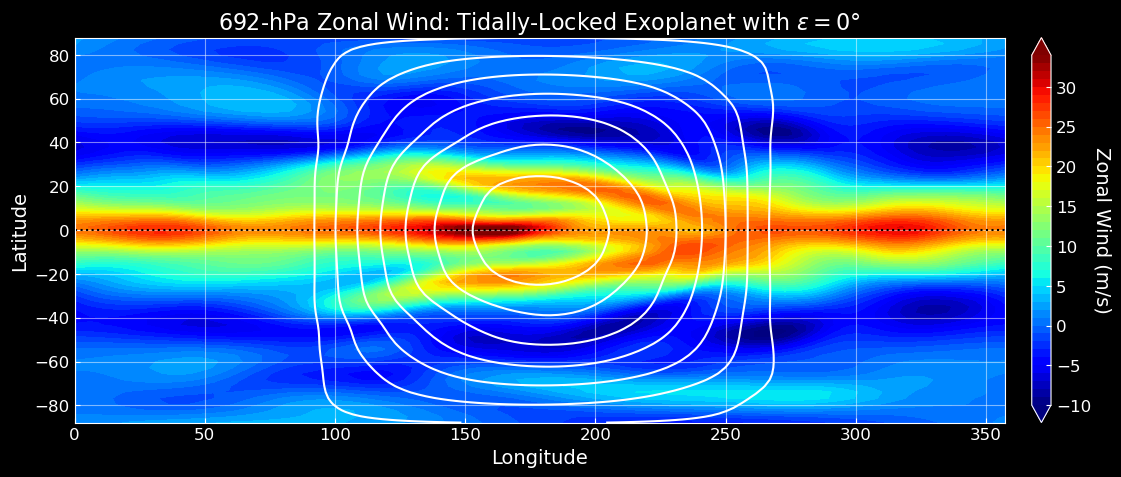

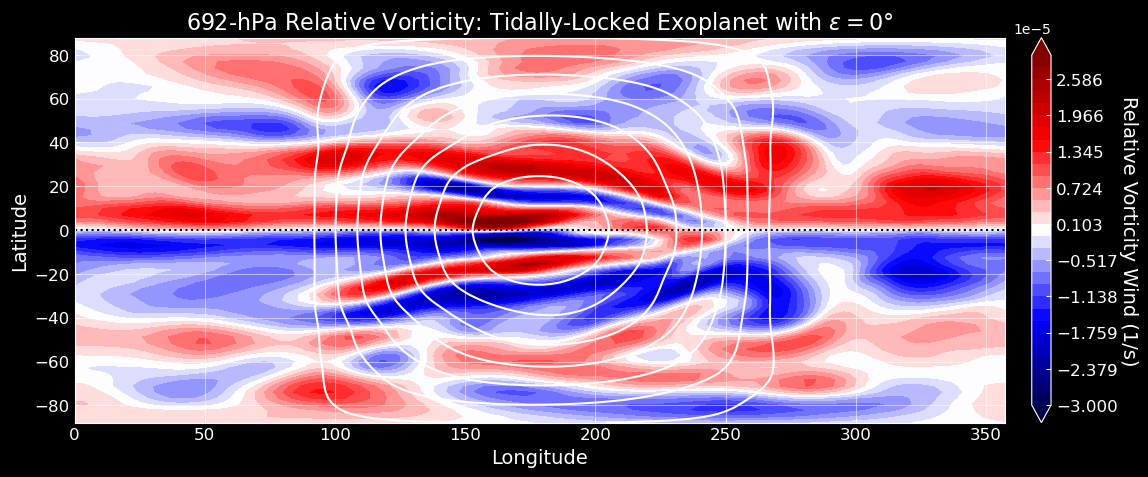

In [50]:
data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity0/run0100/atmos_hourly.nc',decode_times=False)
time = data.time
lon = data.lon
lat = data.lat
pfull = data.pfull
u = data.ucomp
v = data.vcomp
omega = data.omega
temp = data.temp
vort = data.vor
tbar = np.mean(np.mean(temp,axis=0),axis=2)
teq = data.teq
height = data.height

fig,ax = plt.subplots(1,1,figsize=(15,5))
fig.patch.set_facecolor('black')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(lon,lat,temp[:,20].mean('time'),cmap='gnuplot2',levels=np.arange(225,266,1),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(colors='white',labelsize=12,direction='in')
cbar.ax.set_ylabel('Temperature (K)',fontsize=14,rotation=270,labelpad=15,color='white')
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
ax.axhline(0,color='black',linestyle='dotted')
ax.contour(lon,lat,teq[:,20].mean('time'),colors='white')
ax.tick_params(colors='white',labelsize=12,direction='in')
ax.set_xlabel('Longitude',fontsize=14,color='white')
ax.set_ylabel('Latitude',fontsize=14,color='white')
ax.set_title('692-hPa Temperature: Tidally-Locked Exoplanet with $\epsilon = 0\degree$',fontsize=16,color='white')
ax.grid(alpha=0.5,color='white')
plt.show()

fig,ax = plt.subplots(1,1,figsize=(15,5))
fig.patch.set_facecolor('black')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(lon,lat,u[:,20].mean('time'),cmap='jet',levels=np.arange(-10,35,1),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(colors='white',labelsize=12,direction='in')
cbar.ax.set_ylabel('Zonal Wind (m/s)',fontsize=14,rotation=270,labelpad=15,color='white')
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
ax.axhline(0,color='black',linestyle='dotted')
ax.contour(lon,lat,teq[:,20].mean('time'),colors='white')
ax.tick_params(colors='white',labelsize=12,direction='in')
ax.set_xlabel('Longitude',fontsize=14,color='white')
ax.set_ylabel('Latitude',fontsize=14,color='white')
ax.set_title('692-hPa Zonal Wind: Tidally-Locked Exoplanet with $\epsilon = 0\degree$',fontsize=16,color='white')
ax.grid(alpha=0.5,color='white')
plt.show()

fig,ax = plt.subplots(1,1,figsize=(15,5))
fig.patch.set_facecolor('black')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(lon,lat,vort[:,20].mean('time'),cmap='seismic',levels=np.linspace(-3e-5,3e-5,30),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(colors='white',labelsize=12,direction='in')
cbar.ax.set_ylabel('Relative Vorticity Wind (1/s)',fontsize=14,rotation=270,labelpad=15,color='white')
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
ax.axhline(0,color='black',linestyle='dotted')
ax.contour(lon,lat,teq[:,20].mean('time'),colors='white')
ax.tick_params(colors='white',labelsize=12,direction='in')
ax.set_xlabel('Longitude',fontsize=14,color='white')
ax.set_ylabel('Latitude',fontsize=14,color='white')
ax.set_title('692-hPa Relative Vorticity: Tidally-Locked Exoplanet with $\epsilon = 0\degree$',fontsize=16,color='white')
ax.grid(alpha=0.5,color='white')
plt.show()

### Wind anomalies and eddy momentum flux for zero obliquity case

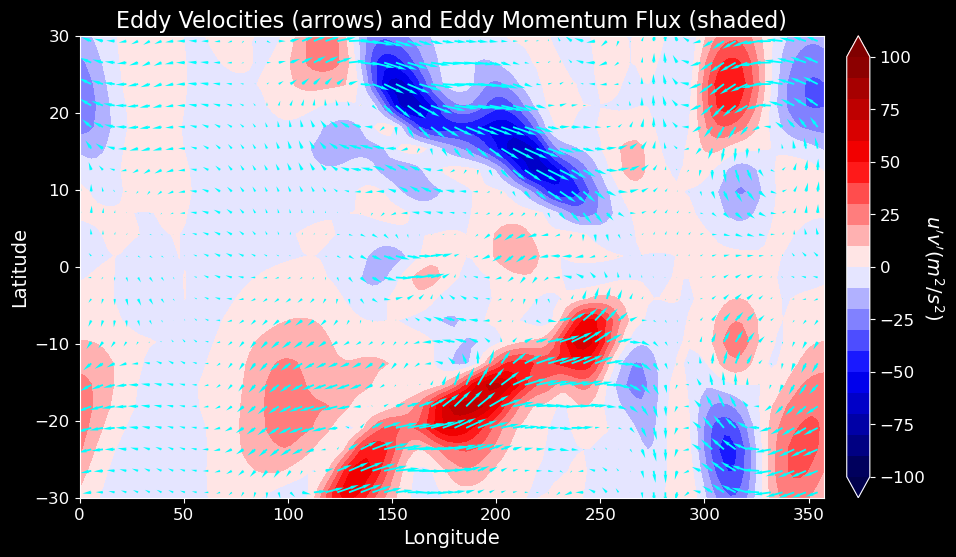

In [55]:
up = u[:,20].mean('time')-u[:,20].mean('time').mean('lon')
vp = v[:,20].mean('time')-v[:,20].mean('time').mean('lon')
fig, ax = plt.subplots(1,1,figsize=(12,6))
fig.patch.set_facecolor('black')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(lon,lat,up*vp,cmap='seismic',levels=np.linspace(-100,100,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0),ticks=np.linspace(-100,100,9))
cbar.ax.tick_params(colors='white',labelsize=12)
cbar.ax.set_ylabel(r"$u'v' (m^2/s^2)$",color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
ax.quiver(lon[::2], lat, up[:,::2], vp[:,::2],headwidth=2,minlength=0.1,color='cyan')
ax.set_ylim(-30,30)
ax.tick_params(colors='white',labelsize=12)
ax.set_xlabel('Longitude',fontsize=14,color='white')
ax.set_ylabel('Latitude',fontsize=14,color='white')
ax.set_title('Eddy Velocities (arrows) and Eddy Momentum Flux (shaded)',fontsize=16,color='white')
plt.show()

### Zonal wind and temperature for obliquity cases

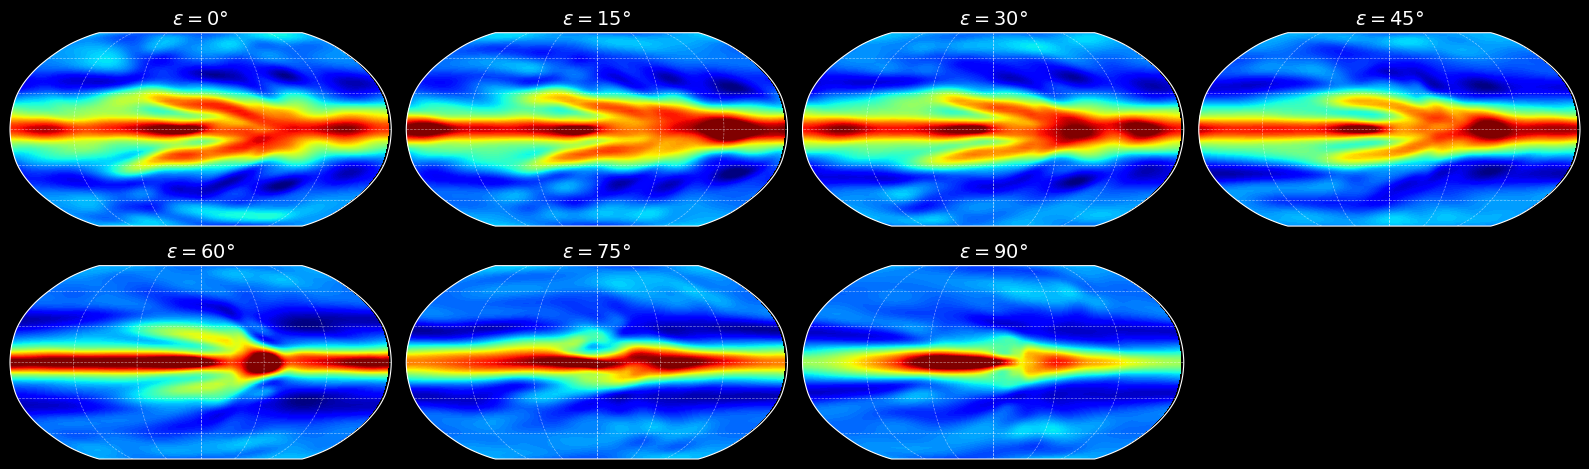

In [1]:
run = ['0', '15', '30', '45', '60', '75', '90']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 5),
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fig.patch.set_facecolor('black')

vmin = -10
vmax = 30

for t in range(len(run)):
    data = xr.open_dataset(f'/home/cwk26/project/gfdl_data/top_down_test_obliquity{run[t]}/run0100/atmos_hourly.nc', decode_times=False)
    
    lon = data.lon
    lat = data.lat
    u = data.ucomp
    teq = data.teq

    ax = axes.flatten()[t]
    ax.set_global()
    ax.set_facecolor('black')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    
    cax = ax.contourf(lon, lat, u[:,20].mean('time'),
                      transform=ccrs.PlateCarree(),
                      levels=np.linspace(vmin, vmax, 100),
                      cmap='jet', extend='both')


    ax.set_title(r'$\epsilon = $'+run[t]+'$\degree$', fontsize=14, color='white')
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='white', alpha=0.5, linestyle='--')

if len(run) < len(axes.flatten()):
    for i in range(len(run), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

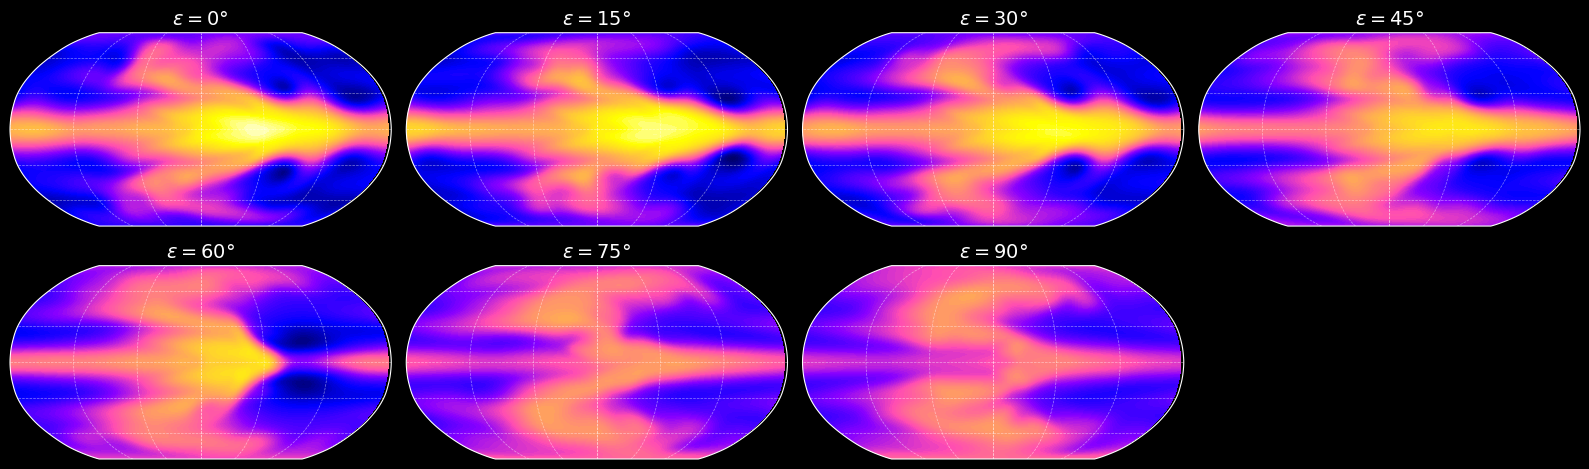

In [3]:
run = ['0', '15', '30', '45', '60', '75', '90']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 5),
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fig.patch.set_facecolor('black')

vmin = 225
vmax = 265

for t in range(len(run)):
    data = xr.open_dataset(f'/home/cwk26/project/gfdl_data/top_down_test_obliquity{run[t]}/run0100/atmos_hourly.nc', decode_times=False)
    
    lon = data.lon
    lat = data.lat
    temp = data.temp
    teq = data.teq

    ax = axes.flatten()[t]
    ax.set_global()
    ax.set_facecolor('black')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    
    cax = ax.contourf(lon, lat, temp[:,20].mean('time'),
                      transform=ccrs.PlateCarree(),
                      levels=np.linspace(vmin, vmax, 100),
                      cmap='gnuplot2', extend='both')

    ax.set_title(r'$\epsilon = $'+run[t]+'$\degree$', fontsize=14, color='white')
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='white', alpha=0.5, linestyle='--')

if len(run) < len(axes.flatten()):
    for i in range(len(run), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])


plt.tight_layout()
plt.show()


### Modes of Variability in the 90 degree obliquity case

#### 50 year

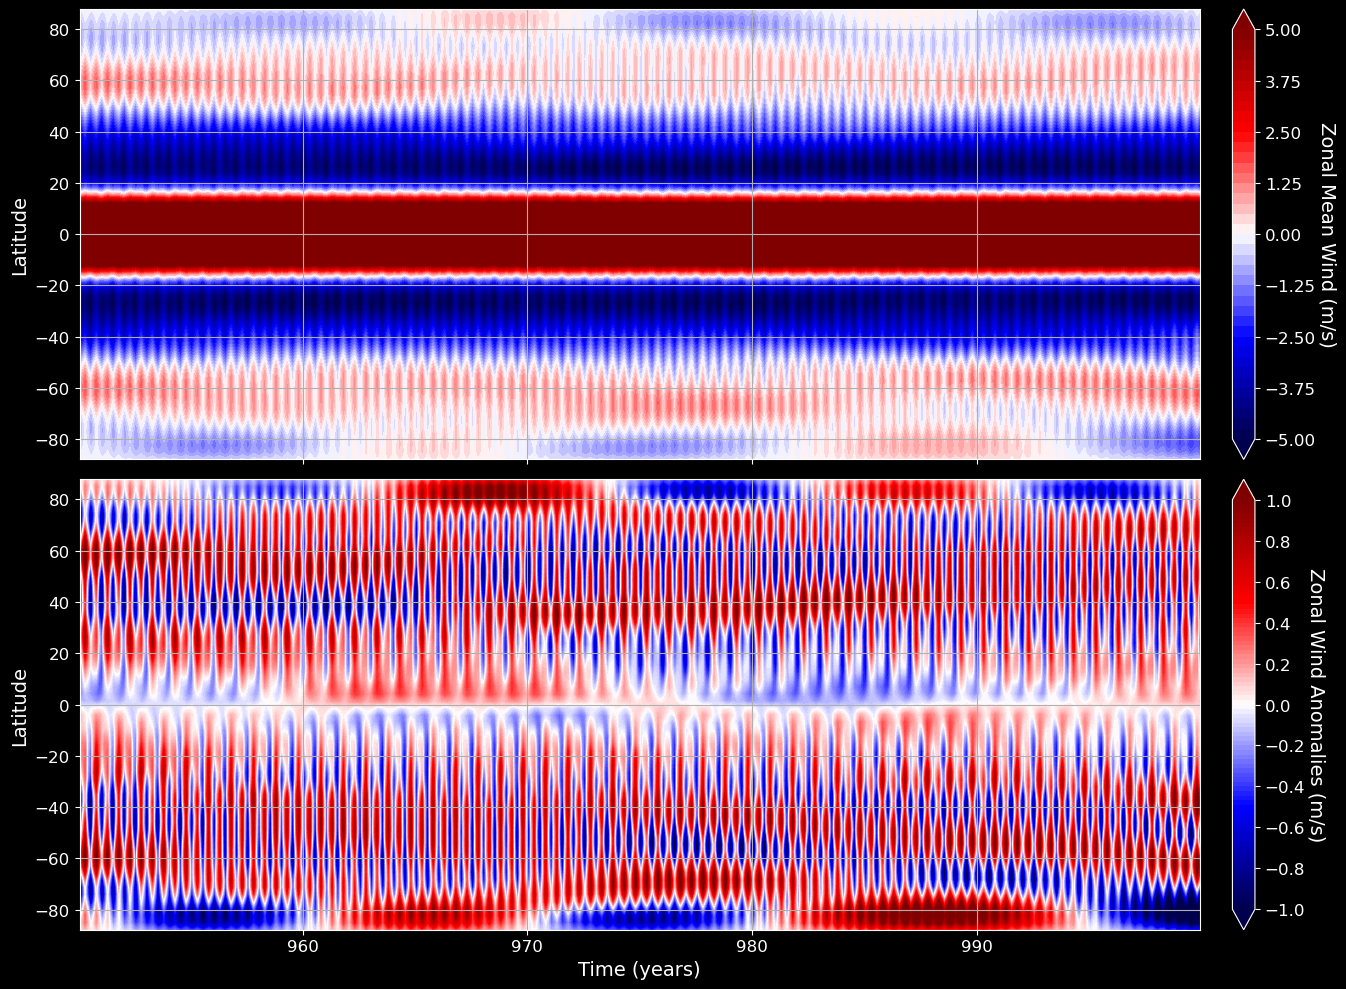

In [57]:
i = 0
for t in range(96,101):
    data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity90/run'+str(t).zfill(4)+'/atmos_hourly.nc',decode_times=False)
    if i==0:
        u = data.ucomp
        time = data.time
    else:
        u = xr.concat([u,data.ucomp],dim='time')
        time = xr.concat([time,data.time],dim='time')
    i+=1

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(15,10),sharex=True)
fig.patch.set_facecolor('black')
ax = axes[0]
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(time,lat,u[:,20,:].mean('lon').T,levels=np.linspace(-5,5,41),cmap='seismic',extend='both')
cbar = plt.colorbar(cax, anchor=(-0.2,0))
cbar.ax.tick_params(colors='white',labelsize=12)
cbar.ax.set_ylabel('Zonal Mean Wind (m/s)',fontsize=14,rotation=270,labelpad=15,color='white')
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
#plt.contour(time,lat,u[:,20,:].mean('lon').T,levels=np.linspace(-5,5,41),colors='black',alpha=0.5)
ax.grid()
ax.tick_params(colors='white',labelsize=12)
ax.set_ylabel('Latitude',fontsize=14,color='white')

ax = axes[1]
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(time,lat,u[:,20,:].mean('lon').T - u[:,20,:].mean('time').mean('lon').T,levels=np.linspace(-1,1,91),cmap='seismic',extend='both')
cbar = plt.colorbar(cax, anchor=(-0.2,0),ticks=np.linspace(-1,1,11))
cbar.ax.tick_params(colors='white',labelsize=12)
cbar.ax.set_ylabel('Zonal Wind Anomalies (m/s)',fontsize=14,rotation=270,labelpad=15,color='white')
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
ax.grid()
ax.tick_params(colors='white',labelsize=12)
ax.set_xlabel('Time (years)',fontsize=14,color='white')
ax.set_ylabel('Latitude',fontsize=14,color='white')
plt.tight_layout()
plt.show()

#### 10 year

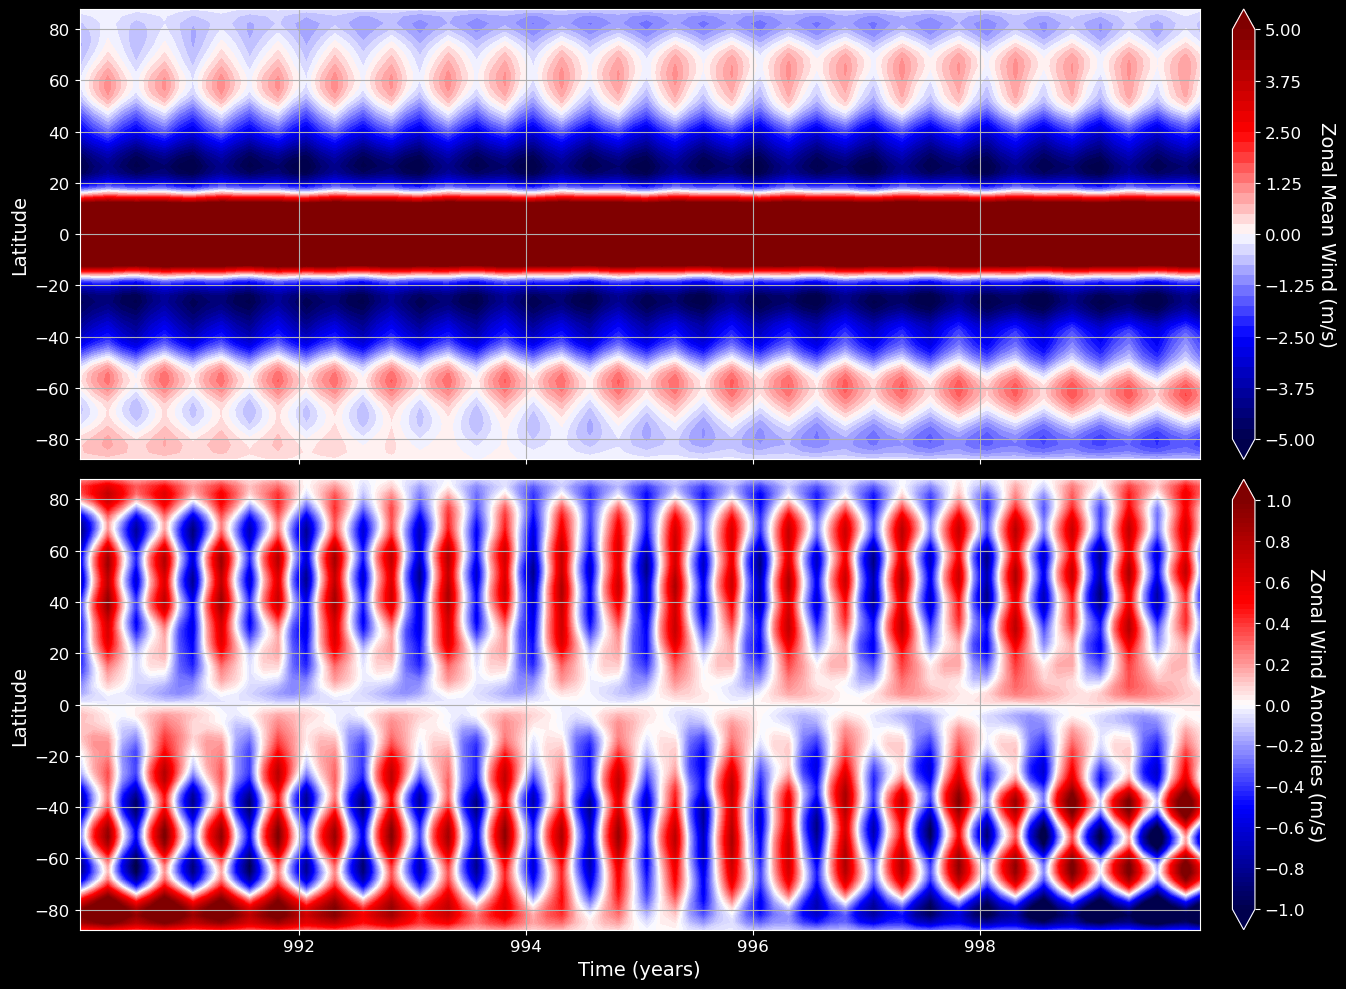

In [58]:
i = 0
for t in range(100,101):
    data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity90/run'+str(t).zfill(4)+'/atmos_hourly.nc',decode_times=False)
    if i==0:
        u = data.ucomp
        time = data.time
    else:
        u = xr.concat([u,data.ucomp],dim='time')
        time = xr.concat([time,data.time],dim='time')
    i+=1

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(15,10),sharex=True)
fig.patch.set_facecolor('black')
ax = axes[0]
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(time,lat,u[:,20,:].mean('lon').T,levels=np.linspace(-5,5,41),cmap='seismic',extend='both')
cbar = plt.colorbar(cax, anchor=(-0.2,0))
cbar.ax.tick_params(colors='white',labelsize=12)
cbar.ax.set_ylabel('Zonal Mean Wind (m/s)',fontsize=14,rotation=270,labelpad=15,color='white')
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
#plt.contour(time,lat,u[:,20,:].mean('lon').T,levels=np.linspace(-5,5,41),colors='black',alpha=0.5)
ax.grid()
ax.tick_params(colors='white',labelsize=12)
ax.set_ylabel('Latitude',fontsize=14,color='white')

ax = axes[1]
for spine in ax.spines.values():
    spine.set_edgecolor('white')
cax = ax.contourf(time,lat,u[:,20,:].mean('lon').T - u[:,20,:].mean('time').mean('lon').T,levels=np.linspace(-1,1,91),cmap='seismic',extend='both')
cbar = plt.colorbar(cax, anchor=(-0.2,0),ticks=np.linspace(-1,1,11))
cbar.ax.tick_params(colors='white',labelsize=12)
cbar.ax.set_ylabel('Zonal Wind Anomalies (m/s)',fontsize=14,rotation=270,labelpad=15,color='white')
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('white')
ax.grid()
ax.tick_params(colors='white',labelsize=12)
ax.set_xlabel('Time (years)',fontsize=14,color='white')
ax.set_ylabel('Latitude',fontsize=14,color='white')
plt.tight_layout()
plt.show()

### Zonal Streamfunction

#### 0 degree case

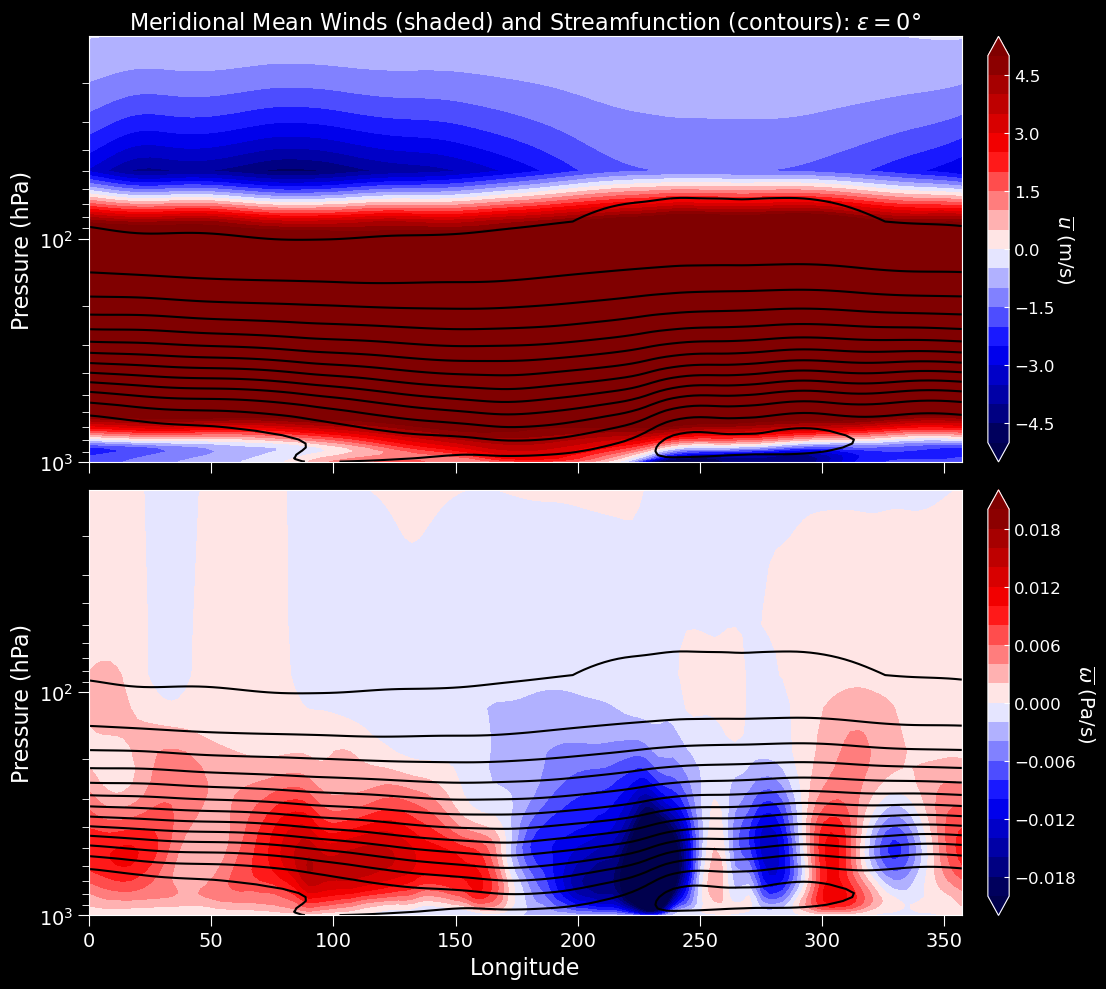

In [60]:
data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity0/run0100/atmos_hourly.nc',decode_times=False)
time = data.time
lon = data.lon
lat = data.lat
pfull = data.pfull
u = data.ucomp
v = data.vcomp
omega = data.omega
temp = data.temp
vort = data.vor
tbar = np.mean(np.mean(temp,axis=0),axis=2)
teq = data.teq
height = data.height

ubar = u.mean('time').mean('lat')
wbar = omega.mean('time').mean('lat')
psi = integrate.cumulative_trapezoid(ubar,pfull,axis=0)

fig,axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
fig.patch.set_facecolor('black')

ax = axes[0]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lon,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lon,pfull,ubar,cmap='seismic',levels=np.linspace(-5,5,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{u}$ (m/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
ax.set_title('Meridional Mean Winds (shaded) and Streamfunction (contours): $\epsilon = 0\degree$',color='white',fontsize=16)
plt.tight_layout()

ax = axes[1]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lon,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lon,pfull,wbar,cmap='seismic',levels=np.linspace(-0.02,0.02,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{\omega}$ (Pa/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_xlabel('Longitude',fontsize=16,color='white')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
plt.tight_layout()
plt.show()

#### 90 degree case

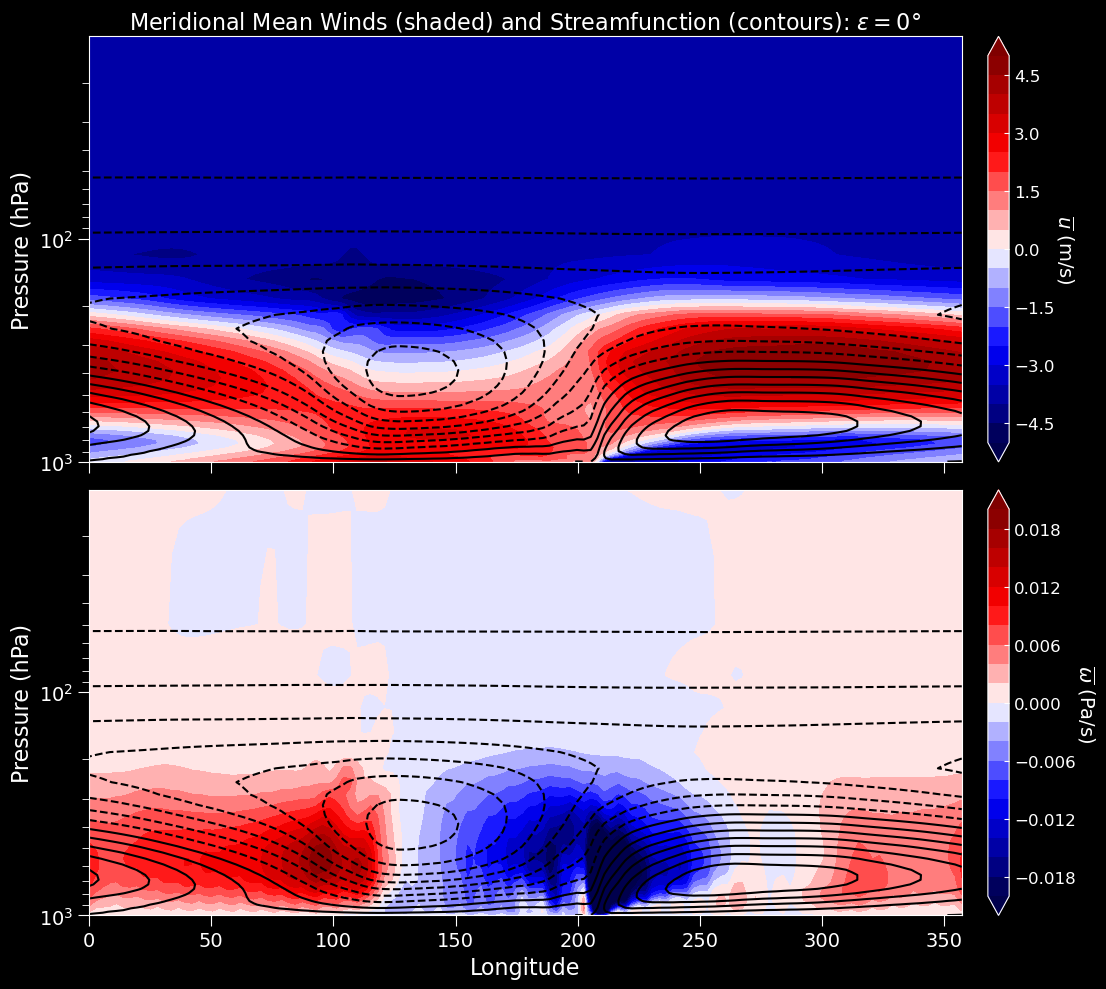

In [61]:
data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity90/run0100/atmos_hourly.nc',decode_times=False)
time = data.time
lon = data.lon
lat = data.lat
pfull = data.pfull
u = data.ucomp
v = data.vcomp
omega = data.omega
temp = data.temp
vort = data.vor
tbar = np.mean(np.mean(temp,axis=0),axis=2)
teq = data.teq
height = data.height

ubar = u.mean('time').mean('lat')
wbar = omega.mean('time').mean('lat')
psi = integrate.cumulative_trapezoid(ubar,pfull,axis=0)

fig,axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
fig.patch.set_facecolor('black')

ax = axes[0]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lon,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lon,pfull,ubar,cmap='seismic',levels=np.linspace(-5,5,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{u}$ (m/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
ax.set_title('Meridional Mean Winds (shaded) and Streamfunction (contours): $\epsilon = 0\degree$',color='white',fontsize=16)
plt.tight_layout()

ax = axes[1]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lon,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lon,pfull,wbar,cmap='seismic',levels=np.linspace(-0.02,0.02,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{\omega}$ (Pa/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_xlabel('Longitude',fontsize=16,color='white')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
plt.tight_layout()
plt.show()

### Meridional Streamfunction

#### 0 degree case

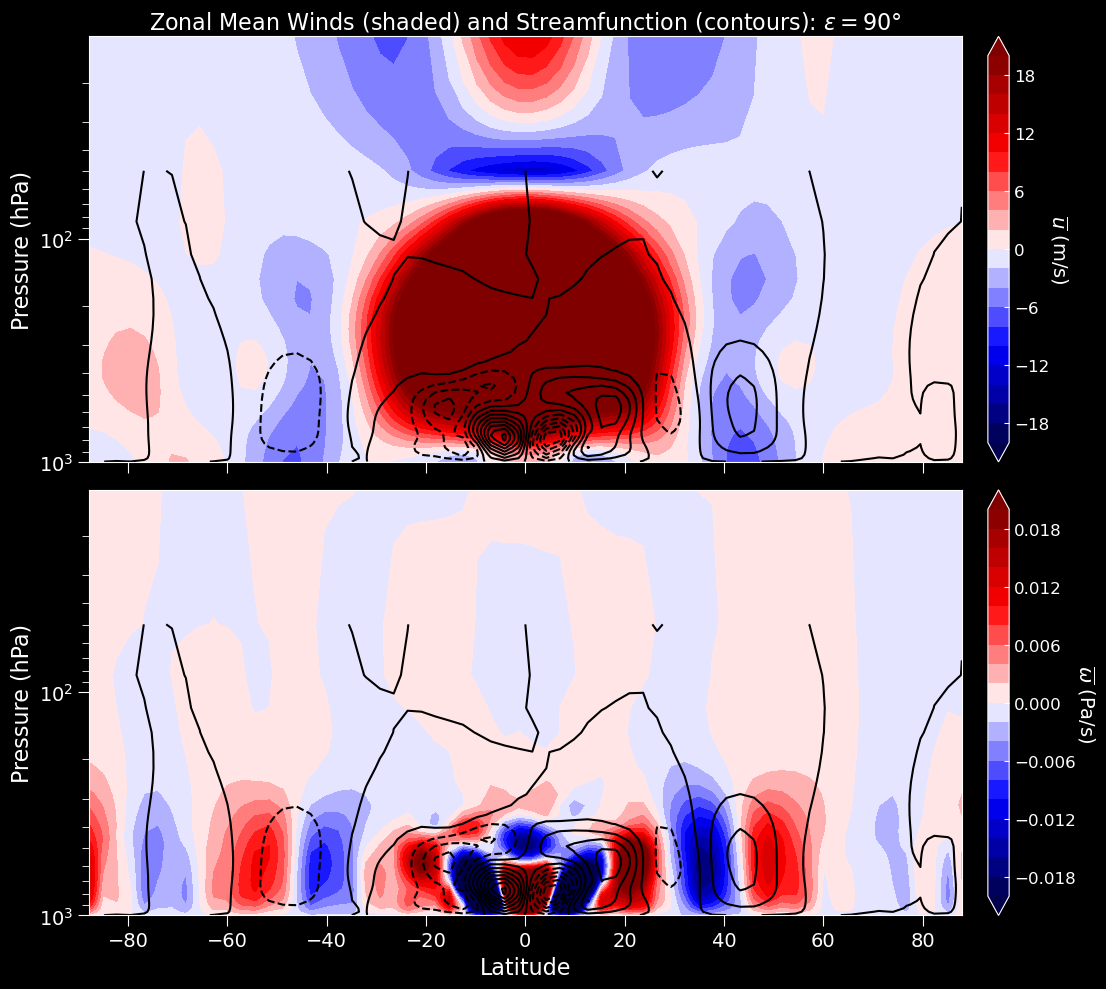

In [62]:
data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity0/run0100/atmos_hourly.nc',decode_times=False)
time = data.time
lon = data.lon
lat = data.lat
pfull = data.pfull
u = data.ucomp
v = data.vcomp
omega = data.omega
temp = data.temp
vort = data.vor
tbar = np.mean(np.mean(temp,axis=0),axis=2)
teq = data.teq
height = data.height

ubar = u.mean('time').mean('lon')
vbar = v.mean('time').mean('lon')
wbar = omega.mean('time').mean('lon')
psi = integrate.cumulative_trapezoid(vbar,pfull,axis=0)

fig,axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
fig.patch.set_facecolor('black')

ax = axes[0]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lat,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lat,pfull,ubar,cmap='seismic',levels=np.linspace(-20,20,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{u}$ (m/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
ax.set_title('Zonal Mean Winds (shaded) and Streamfunction (contours): $\epsilon = 90\degree$',color='white',fontsize=16)
plt.tight_layout()

ax = axes[1]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lat,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lat,pfull,wbar,cmap='seismic',levels=np.linspace(-0.02,0.02,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{\omega}$ (Pa/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_xlabel('Latitude',fontsize=16,color='white')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
plt.tight_layout()
plt.show()

#### 90 degree case

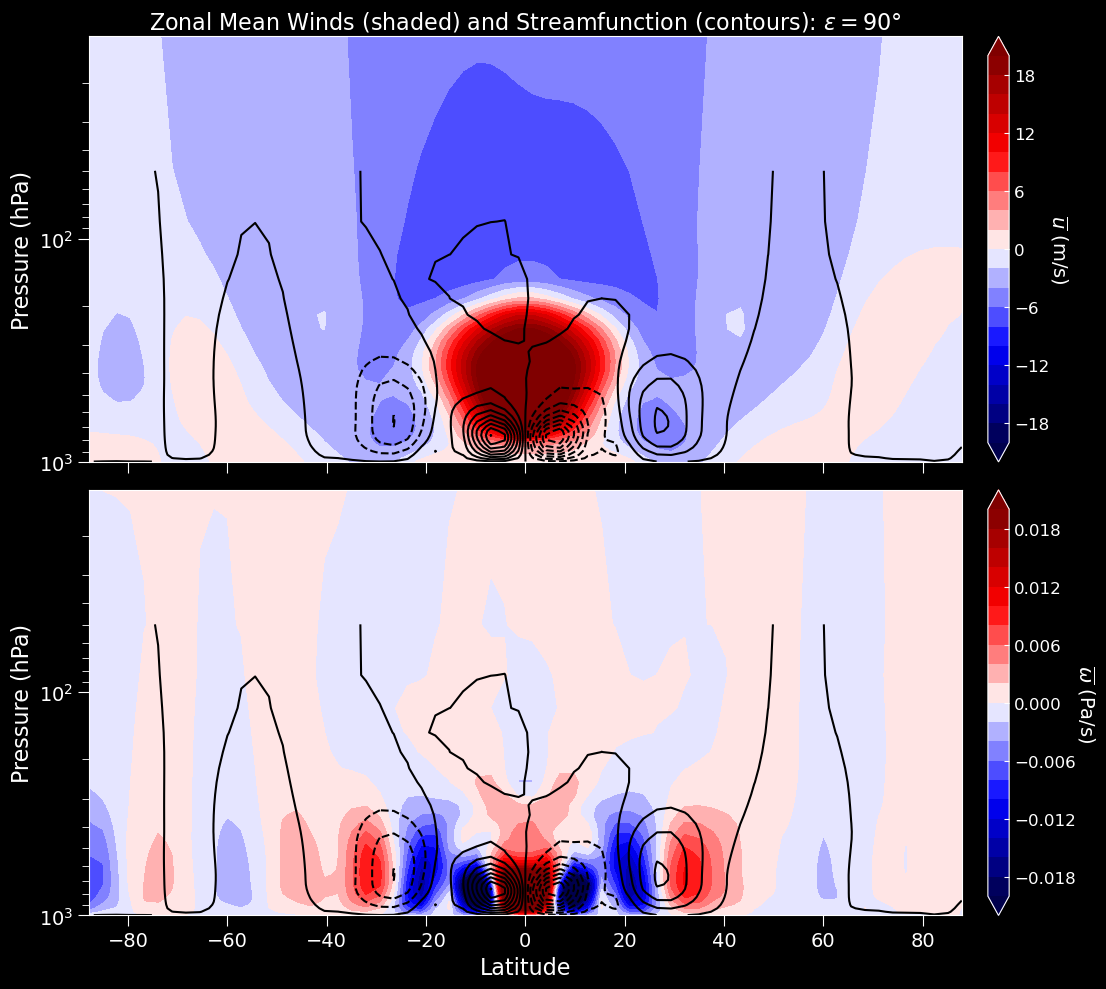

In [63]:
data = xr.open_dataset('/home/cwk26/project/gfdl_data/top_down_test_obliquity90/run0100/atmos_hourly.nc',decode_times=False)
time = data.time
lon = data.lon
lat = data.lat
pfull = data.pfull
u = data.ucomp
v = data.vcomp
omega = data.omega
temp = data.temp
vort = data.vor
tbar = np.mean(np.mean(temp,axis=0),axis=2)
teq = data.teq
height = data.height

ubar = u.mean('time').mean('lon')
vbar = v.mean('time').mean('lon')
wbar = omega.mean('time').mean('lon')
psi = integrate.cumulative_trapezoid(vbar,pfull,axis=0)

fig,axes = plt.subplots(2,1,figsize=(12,10),sharex=True)
fig.patch.set_facecolor('black')

ax = axes[0]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lat,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lat,pfull,ubar,cmap='seismic',levels=np.linspace(-20,20,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{u}$ (m/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
ax.set_title('Zonal Mean Winds (shaded) and Streamfunction (contours): $\epsilon = 90\degree$',color='white',fontsize=16)
plt.tight_layout()

ax = axes[1]
for spine in ax.spines.values():                 
    spine.set_edgecolor('white')
ax.contour(lat,pfull[1:],psi,colors='black',levels=15)
cax = ax.contourf(lat,pfull,wbar,cmap='seismic',levels=np.linspace(-0.02,0.02,21),extend='both')
cbar = plt.colorbar(cax,anchor=(-0.2,0))
cbar.ax.tick_params(direction='in',colors='white',labelsize=12)
cbar.ax.set_ylabel('$\overline{\omega}$ (Pa/s)',color='white',fontsize=14,rotation=270,labelpad=15)
for spine in cbar.ax.spines.values():                 
    spine.set_edgecolor('white')
ax.set_ylim(1000,np.min(pfull))
ax.set_yscale('log')
ax.set_xlabel('Latitude',fontsize=16,color='white')
ax.set_ylabel('Pressure (hPa)',fontsize=16,color='white')
ax.tick_params(length=8,which='major',labelsize=14,colors='white')
ax.tick_params(length=5,which='minor',colors='white')
plt.tight_layout()
plt.show()